In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
import statsmodels.tsa.api as smt
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

Сначала рассмотрим нестационарный ряд.

In [2]:
data = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")['Count']

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


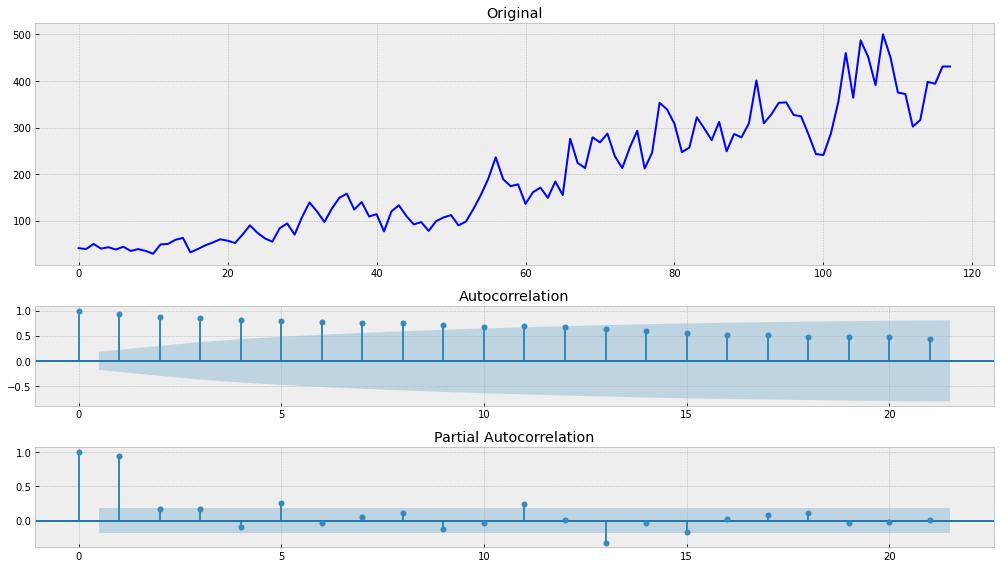

In [5]:
tsplot(data)

В ряду точно присутсвует тренд, поэтому скорее всего подойдет двойное экспоненциальное сглаживание. Наличие сезонной компоненты пока не очевидно.

In [6]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [7]:
train, test, val = data[:100], data[100:110], data[110:]

In [8]:
def mse_cross_val_dema(X):
    alpha, beta = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]

        result = double_ema(train_split_ts, alpha, beta)
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)

    return np.mean(np.array(errors))

In [9]:
opt = minimize(mse_cross_val_dema, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [10]:
alpha_opt, beta_opt = opt.x
print(opt)

      fun: 9623.085759195734
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00363798,  0.00436557])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 57
      nit: 18
   status: 0
  success: True
        x: array([0.77319437, 0.18361095])


In [11]:
def plot_dema(alpha, beta):
    dema = double_ema(data, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(data, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

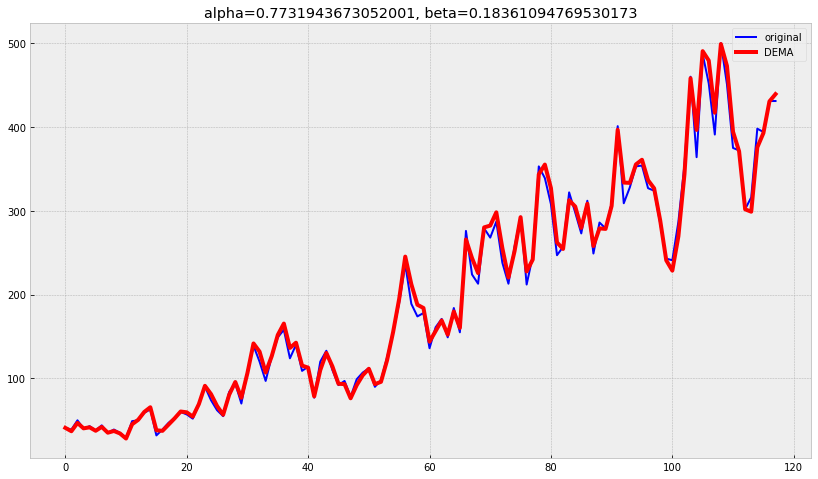

In [12]:
plot_dema(alpha_opt, beta_opt)

In [13]:
def single_ema(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [14]:
def mse_cross_val_ema(X):
    alpha = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]

        result = single_ema(train_split_ts, alpha)
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)

    return np.mean(np.array(errors))

In [15]:
opt = minimize(mse_cross_val_ema, x0 = [0], method="L-BFGS-B", bounds = [(0, 1)])

In [16]:
alpha_opt = opt.x
print(alpha_opt)
print(opt)

[1.]
      fun: 9912.199999999999
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-115.30646589])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([1.])


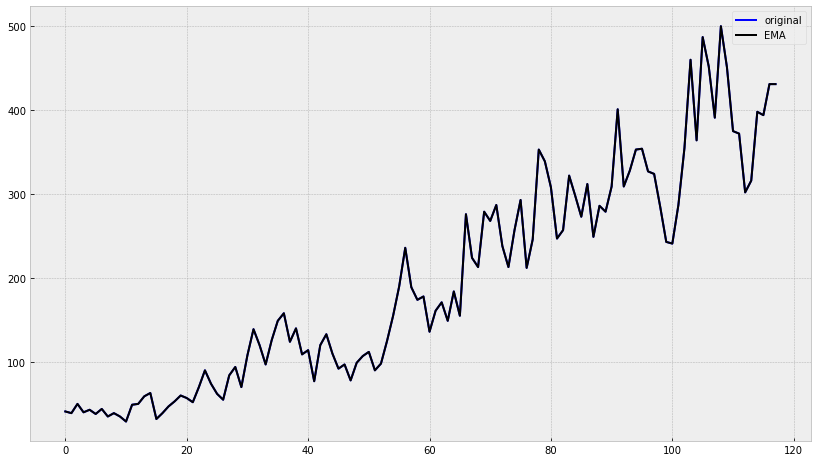

In [17]:
ema = single_ema(data, alpha_opt)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(data, color='blue',label='original')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plt.legend()

alpha = 1 соответствует ситуации "наивного прогнозирования", т.е., на каждом шаге в качестве прогнозного значения принимается значение на предыдущем шаге.
Значение минимизируемой функции для двойного экспоненциального сглаживания составило 9623, а для простого экспоненциального сглаживания 9912, что позволяет сделать вывод о том, что двойное экспоненциальное сглаживание является оптимальным по критерию минимизации MSE.

Приведем ряд к стационарному виду.

In [18]:
data_stat = boxcox(data, 0)
data_stat = data_stat[1:] - data_stat[:-1]

In [19]:
data_stat = pd.Series(data_stat)

In [20]:
train, test, val = data_stat[:100], data_stat[100:110], data_stat[110:]

In [21]:
opt = minimize(mse_cross_val_ema, x0 = [0], method="L-BFGS-B", bounds = [(0, 1)])

In [22]:
alpha_opt = opt.x
print(alpha_opt)
print(opt)

[0.04960197]
      fun: 0.04296675267973843
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.22402088e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 22
      nit: 7
   status: 0
  success: True
        x: array([0.04960197])


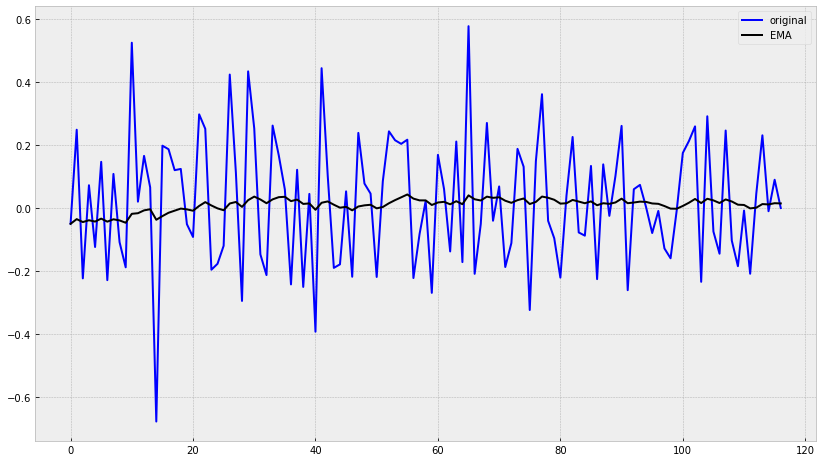

In [23]:
ema = single_ema(data_stat, alpha_opt)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(data_stat, color='blue',label='original')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plt.legend()

Для временного ряда после устранения размаха дисперсии и однократного дифференцирования значение alpha составило приблизительно 0,05, что соответствует большему весу исторических данных в ущерб новым данным.